In [28]:
import torch
import argparse
import os
import sys
import yaml
import datetime
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
from pipelines.sd_controlnet_rave import RAVE
from pipelines.sd_multicontrolnet_rave import RAVE_MultiControlNet
from IPython.display import Video, Image
import PIL
import utils.constants as const
import utils.video_grid_utils as vgu
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [2]:

def init_device():
    device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device_name)
    return device

def init_paths(input_ns):
    if input_ns.save_folder == None or input_ns.save_folder == '':
        input_ns.save_folder = input_ns.video_name.replace('.mp4', '').replace('.gif', '')
    else:
        input_ns.save_folder += f"/{input_ns.video_name.replace('.mp4', '').replace('.gif', '')}"
    save_dir = f'{const.OUTPUT_PATH}/{input_ns.save_folder}'
    os.makedirs(save_dir, exist_ok=True)
    save_idx = max([int(x[-5:]) for x in os.listdir(save_dir)])+1 if os.listdir(save_dir) != [] else 0
    input_ns.save_path = f'{save_dir}/{input_ns.positive_prompts}-{str(save_idx).zfill(5)}'
    

    input_ns.video_path = f'{const.MP4_PATH}/{input_ns.video_name}.mp4'
    
    if '-' in input_ns.preprocess_name:
        input_ns.hf_cn_path = [const.PREPROCESSOR_DICT[i] for i in input_ns.preprocess_name.split('-')]
    else:
        input_ns.hf_cn_path = const.PREPROCESSOR_DICT[input_ns.preprocess_name]
    input_ns.hf_path = "runwayml/stable-diffusion-v1-5"
    
    input_ns.inverse_path = f'{const.GENERATED_DATA_PATH}/inverses/{input_ns.video_name}/{input_ns.preprocess_name}_{input_ns.model_id}_{input_ns.grid_size}x{input_ns.grid_size}_{input_ns.pad}'
    input_ns.control_path = f'{const.GENERATED_DATA_PATH}/controls/{input_ns.video_name}/{input_ns.preprocess_name}_{input_ns.grid_size}x{input_ns.grid_size}_{input_ns.pad}'
    os.makedirs(input_ns.control_path, exist_ok=True)
    os.makedirs(input_ns.inverse_path, exist_ok=True)
    os.makedirs(input_ns.save_path, exist_ok=True)
    return input_ns
    
def run(input_ns):

    if 'model_id' not in list(input_ns.__dict__.keys()):
        input_ns.model_id = "None"
    device = init_device()
    input_ns = init_paths(input_ns)

    input_ns.image_pil_list = vgu.prepare_video_to_grid(input_ns.video_path, input_ns.sample_size, input_ns.grid_size, input_ns.pad)
    print(input_ns.video_path )
    input_ns.sample_size = len(input_ns.image_pil_list)
    print(f'Frame count: {len(input_ns.image_pil_list)}')

    controlnet_class = RAVE_MultiControlNet if '-' in str(input_ns.controlnet_conditioning_scale) else RAVE
    

    CN = controlnet_class(device)


    CN.init_models(input_ns.hf_cn_path, input_ns.hf_path, input_ns.preprocess_name, input_ns.model_id)
    
    input_dict = vars(input_ns)
    print(input_dict)
    yaml_dict = {k:v for k,v in input_dict.items() if k != 'image_pil_list'}

    start_time = datetime.datetime.now()
    if '-' in str(input_ns.controlnet_conditioning_scale):
        res_vid, control_vid_1, control_vid_2 = CN(input_dict)
    else: 
        res_vid, control_vid = CN(input_dict)
    end_time = datetime.datetime.now()
    save_name = f"{'-'.join(input_ns.positive_prompts.split())}_cstart-{input_ns.controlnet_guidance_start}_gs-{input_ns.guidance_scale}_pre-{'-'.join((input_ns.preprocess_name.replace('-','+').split('_')))}_cscale-{input_ns.controlnet_conditioning_scale}_grid-{input_ns.grid_size}_pad-{input_ns.pad}_model-{input_ns.model_id.split('/')[-1]}"
    res_vid[0].save(f"{input_ns.save_path}/{save_name}.gif", save_all=True, append_images=res_vid[1:], optimize=False, loop=10000)
    # control_vid[0].save(f"{input_ns.save_path}/control_{save_name}.gif", save_all=True, append_images=control_vid[1:], optimize=False, loop=10000)

    yaml_dict['total_time'] = (end_time - start_time).total_seconds()
    yaml_dict['total_number_of_frames'] = len(res_vid)
    yaml_dict['sec_per_frame'] = yaml_dict['total_time']/yaml_dict['total_number_of_frames']
    with open(f'{input_ns.save_path}/config.yaml', 'w') as yaml_file:
        yaml.dump(yaml_dict, yaml_file)
    
    if '-' in str(input_ns.controlnet_conditioning_scale):
        return (res_vid, control_vid_1, control_vid_2)
    else: 
        return (res_vid, control_vid)



## Set Parameters

In [3]:
input_ns = argparse.Namespace(**{})
input_ns.video_name = "truck"  # specify the name of the video existing in the data/mp4_videos folder (e.g. data/mp4_videos/truck.mp4)
input_ns.preprocess_name = 'depth_zoe'  # specify the name of the condition used for the video (e.g. depth_zoe condition)

input_ns.batch_size = 4  # denotes the batch size of grids (e.g. 4 grids run in parallel)
input_ns.batch_size_vae = 1  # denotes the batch size for the VAE (e.g. 1 grid runs in parallel for the VAE)

input_ns.cond_step_start = 0.0  # denotes the step to start conditioning

input_ns.controlnet_conditioning_scale = 1.0  # denotes the scale of the conditioning
input_ns.controlnet_guidance_end = 1.0  # denotes the end of the controlnet guidance
input_ns.controlnet_guidance_start = 0.0  # denotes the start of the controlnet guidance

input_ns.give_control_inversion = True  # denotes whether to give control to the inversion

input_ns.grid_size = 3  # denotes the size of each grid (e.g. grid_size x grid_size)
input_ns.sample_size = -1  # denotes the number of grids to be generated (-1 for the full video)
input_ns.pad = 1  # denotes the padding of the video (if 1, use the same video)
input_ns.guidance_scale = 7.5  # denotes the scale of the guidance
input_ns.inversion_prompt = ''  # denotes the inversion prompt

input_ns.is_ddim_inversion = True  # denotes whether to use ddim for inversion
input_ns.is_shuffle = True  # denotes whether to applying shuffling between the grids

input_ns.negative_prompts = ""  # denotes the negative prompts
input_ns.num_inference_steps = 50  # denotes the number of inference steps during the sampling process
input_ns.num_inversion_step = 50  # denotes the number of inversion steps during the inversion process
input_ns.positive_prompts = "Wooden trucks drive on a racetrack"  # denotes the positive prompts
input_ns.save_folder = 'truck'  # denotes the name of the folder to save the results under results

input_ns.seed = 0  # denotes the seed
input_ns.model_id = 'None'  # None to use stable diffusion v1.5, otherwise use the model id

## Run RAVE

In [29]:
res = run(input_ns)
save_dir_name = 'truck'
save_dir = f'assets/notebook-generated/{save_dir_name}'
os.makedirs(save_dir, exist_ok=True)
if len(res) == 3:
    res_vid, control_vid_1, control_vid_2 = res
    control_vid_1[0].save(f"{save_dir}/control.gif", save_all=True, append_images=control_vid_1[1:], loop=0)
    control_vid_2[0].save(f"{save_dir}/control_2.gif", save_all=True, append_images=control_vid_2[1:], loop=0)
    res_vid[0].save(f"{save_dir}/result.gif", save_all=True, append_images=res_vid[1:], loop=0)
else:
    res_vid, control_vid = res
    control_vid[0].save(f"{save_dir}/control.gif", save_all=True, append_images=control_vid[1:], loop=0)
    res_vid[0].save(f"{save_dir}/result.gif", save_all=True, append_images=res_vid[1:], loop=0)

/home/okara7/Desktop/CVPR-2024/RAVE/data/mp4_videos/truck.mp4
Frame count: 2
{'video_name': 'truck', 'preprocess_name': 'depth_zoe', 'batch_size': 4, 'batch_size_vae': 1, 'cond_step_start': 0.0, 'controlnet_conditioning_scale': 1.0, 'controlnet_guidance_end': 1.0, 'controlnet_guidance_start': 0.0, 'give_control_inversion': True, 'grid_size': 3, 'sample_size': 2, 'pad': 1, 'guidance_scale': 7.5, 'inversion_prompt': '', 'is_ddim_inversion': True, 'is_shuffle': True, 'negative_prompts': '', 'num_inference_steps': 50, 'num_inversion_step': 50, 'positive_prompts': 'Wooden trucks drive on a racetrack', 'save_folder': 'truck/truck/truck/truck', 'seed': 0, 'model_id': 'None', 'save_path': '/home/okara7/Desktop/CVPR-2024/RAVE/results/12-08-2023/truck/truck/truck/truck/Wooden trucks drive on a racetrack-00000', 'video_path': '/home/okara7/Desktop/CVPR-2024/RAVE/data/mp4_videos/truck.mp4', 'hf_cn_path': 'lllyasviel/control_v11f1p_sd15_depth', 'hf_path': 'runwayml/stable-diffusion-v1-5', 'inverse_

reverse_diffusion: 50it [00:51,  1.02s/it]


## Results

#### Original Video

In [37]:
Video(filename=input_ns.video_path)

#### Edited Video

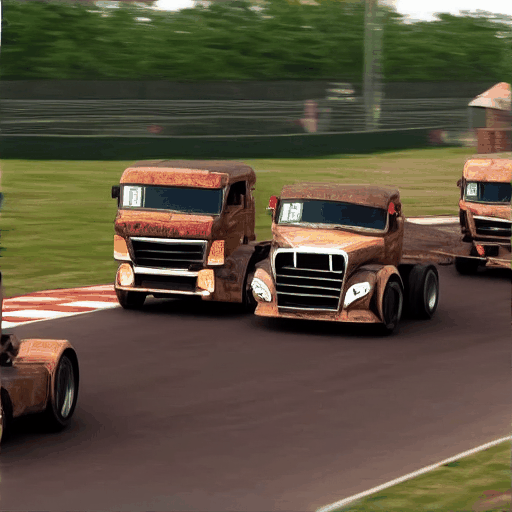

In [35]:
Image(filename=f"{save_dir}/result.gif")

#### Control

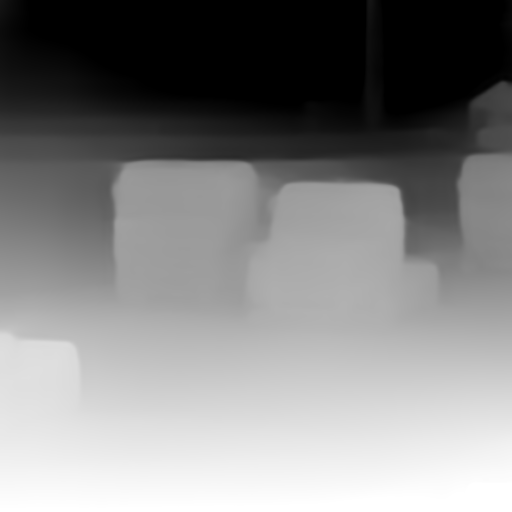

In [38]:
Image(filename=f"{save_dir}/control.gif")